In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from typing import List, Tuple
import numpy as np
from utils import BrainGraphDataset, get_data_labels
import os
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

class VGAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super(VGAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



def loss_function_gmm(x_recon, x, mu, logvar, n_components=3):
    MSE = nn.functional.mse_loss(x_recon, x, reduction='sum')
    
    # Calculate the GMM loss
    gmm = GaussianMixture(n_components=n_components)
    z = mu.detach().cpu().numpy()
    gmm.fit(z)
    gmm_loss = -gmm.score(z)

    return MSE + gmm_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class LatentMLP(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        super(LatentMLP, self).__init__()
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(latent_dim * 2 + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, mu, logvar, baseline_bdi):
        out = torch.cat((mu, logvar, baseline_bdi), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        return out


In [7]:
# instantiate the VGAE model
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100
output_dim = 1
lr = 1e-3
batch_size = 128
num_epochs = 300


categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

annotations = 'annotations.csv'

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

atlas = 'schaefer'
dataroot = f'fc_matrices/correlation_matrices/{atlas}/'
cwd = os.getcwd() + '/'

vgae = VGAE(input_dim, hidden_dim, latent_dim)

# load the trained VGAE weights
vgae.load_state_dict(torch.load('vgae_weights/gmm_3_hidden256_latent64.pt'))

# freeze the weights of the VGAE
for param in vgae.parameters():
    param.requires_grad = False

# instantiate the LatentMLP model
mlp = LatentMLP(latent_dim, hidden_dim, output_dim)

# define the optimizer and the loss function
lr = 0.001
optimizer = optim.Adam(mlp.parameters(), lr=lr)
criterion = nn.MSELoss()

dataroot = 'fc_matrices/psilo_ica_100_before'
cwd = os.getcwd() + '/'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert the model to the device
vgae.to(device)

# Convert the MLP to the device
mlp.to(device)

psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=data_labels, setting='flat_graph')

# Define the train, validation, and test ratios
train_ratio = 1
val_ratio = 0
test_ratio = 0

# Get the number of samples in the dataset
num_samples = len(psilo_dataset)

# Calculate the number of samples for each set
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Split the dataset into train, validation, and test sets
train_set, val_set, test_set = torch.utils.data.random_split(psilo_dataset, [train_size, val_size, test_size])

# Define the dataloaders for each set

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
if not val_ratio == 0:
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)
if not test_ratio == 0:
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

best_val_loss = float('inf')
best_model_state = None

# train the MLP on the new dataset
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
    
        # Convert inputs and labels to float and move to device
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)        
        
        base_bdi = inputs[:, -2:]
        graph = inputs[:, :-2]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # get the latent embeddings from the VGAE
        _, mu, logvar = vgae(graph)
        
        # pass the latent embeddings through the MLP
        
        outputs = mlp(mu, logvar, base_bdi)
        
        # calculate the loss and backpropagate
        loss = criterion(outputs.view(-1), labels.view(-1))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    if not val_ratio == 0:
        # Validation check
        val_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data

                inputs = inputs.float().to(device)
                labels = labels.float().to(device)


                base_bdi = inputs[:, -2:]
                graph = inputs[:, :-2]

                _, mu, logvar = vgae(graph)
                outputs = mlp(mu, logvar, base_bdi)

                val_loss += criterion(outputs.view(-1), labels.view(-1)).item()
        # Save the best model so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = mlp.state_dict()

    # Print statistics and perform testing every 5 epochs
    if epoch % 10 == 9:
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss))
        running_loss = 0.0

print('Finished training') 

[10,     1] loss: 96.022
[20,     1] loss: 100.126
[30,     1] loss: 95.837
[40,     1] loss: 93.221
[50,     1] loss: 91.189
[60,     1] loss: 88.823
[70,     1] loss: 84.854
[80,     1] loss: 77.653
[90,     1] loss: 63.566
[100,     1] loss: 48.800
[110,     1] loss: 43.809
[120,     1] loss: 36.940
[130,     1] loss: 30.340
[140,     1] loss: 30.681
[150,     1] loss: 21.320
[160,     1] loss: 20.798
[170,     1] loss: 14.393
[180,     1] loss: 14.724
[190,     1] loss: 12.605
[200,     1] loss: 8.154
[210,     1] loss: 7.171
[220,     1] loss: 7.093
[230,     1] loss: 9.438
[240,     1] loss: 5.701
[250,     1] loss: 2.319
[260,     1] loss: 4.719
[270,     1] loss: 2.499
[280,     1] loss: 0.887
[290,     1] loss: 0.628
[300,     1] loss: 1.113
Finished training


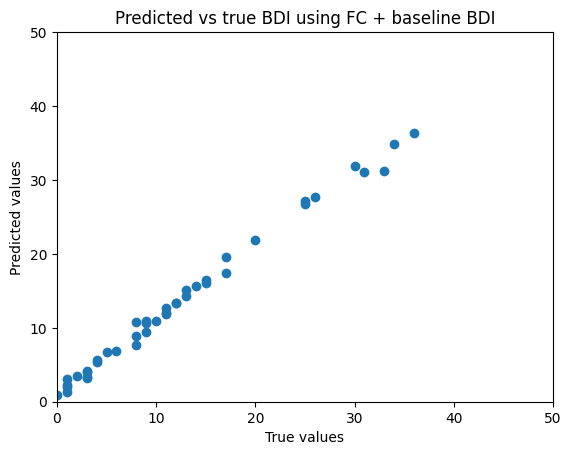

Test loss: 0.000


In [8]:
# Load the best model and perform final testing
# mlp.load_state_dict(best_model_state)

import matplotlib.pyplot as plt

# Evaluate the model on the test set and plot the results
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        inputs = inputs.float().to(device)
        labels = labels.float().to(device)
        
        base_bdi = inputs[:, -2:]
        graph = inputs[:, :-2]
        
        _, mu, logvar = vgae(graph)
        outputs = mlp(mu, logvar, base_bdi)
        
        # Convert back to CPU and numpy arrays for plotting
        labels = labels.cpu().numpy().reshape(-1)
        predictions = outputs.cpu().numpy().reshape(-1)

        # Plot the results
        plt.scatter(labels, predictions)
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        plt.title('Predicted vs true BDI using FC + baseline BDI')
        plt.xlim([0,50])
        plt.ylim([0,50])
        plt.show()

# Print the test loss
print('Test loss: %.3f' % test_loss)